# Visualizing CARTs with admissions data

Using the admissions data from earlier in the course, build CARTs, look at how they work visually, and compare their performance to more standard, parametric models.


---

### Install and load the packages required to visually show decision tree branching

You will need to first:

1. Install `graphviz` with homebrew (on OSX - not sure what linux uses). The command will be `brew install graphviz`
- Install `pydotplus` with `pip install pydotplus`
- Load the packages as shown below (you may need to restart the kernel after the installations.)

In [25]:
# REQUIREMENTS:
# pip install pydotplus
# brew install graphviz

# Use graphviz to make a chart of the regression tree decision points:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

---

### Load in admissions data and other python packages

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm



plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [27]:
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeRegressor

In [28]:
admit = pd.read_csv('assets/admissions.csv')

In [29]:
admit.head()
admit = admit.drop_duplicates()
admit.dropna(inplace=True)

---

### Create regression and classification X, y data

The regression data will be:

    Xr = [admit, gre, prestige]
    yr = gpa
    
The classification data will be:

    Xc = [gre, gpa, prestige]
    yc = admit

In [30]:
Xr = admit[['admit','gre','prestige']]
yr = admit.gpa.values

Xc = admit[['gpa','gre','prestige']]
yc = admit.admit.values

---

### Cross-validate regression and logistic regression on the data

Fit a linear regression for the regression problem and a logistic for the classification problem. Cross-validate the R2 and accuracy scores.

In [31]:
Xr = sm.add_constant(Xr)
# Note the difference in argument order
model = sm.OLS(yr, Xr).fit()
predictions = model.predict(Xr)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     22.93
Date:                Thu, 07 Sep 2017   Prob (F-statistic):           1.09e-13
Time:                        16:24:21   Log-Likelihood:                -142.11
No. Observations:                 392   AIC:                             292.2
Df Residuals:                     388   BIC:                             308.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6558      0.109     24.433      0.000       2.442       2.870
admit          0.0813      0.040      2.049      0.041       0.003       0.159
gre            0.0012      0.000      7.561      0.000       0.001       0.001
prestige       0.0065      0.019      0.338      0.736      -0.031       0.045
==============================================================================
Omnibus:                        5.689   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                5.654
Skew:                          -0.263   Prob(JB):                       0.0592
Kurtosis:                       2.737   Cond. No.                     3.70e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
from sklearn import linear_model
mod = linear_model.LinearRegression()
np.mean(cross_val_score(mod,Xr,yr,scoring='r2'))

0.13433278096838749

In [33]:
Xc = sm.add_constant(Xc)
# Note the difference in argument order
model = sm.Logit(yc, Xc).fit()
predictions = model.predict(Xr)
model.summary2()


Optimization terminated successfully.
         Current function value: 0.574528
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.076     
Dependent Variable: y                AIC:              458.4302  
Date:               2017-09-07 16:24 BIC:              474.3152  
No. Observations:   392              Log-Likelihood:   -225.22   
Df Model:           3                LL-Null:          -243.86   
Df Residuals:       388              LLR p-value:      4.0009e-08
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
const         -3.0647    1.1459  -2.6745  0.0075  -5.3107  -0.8188
gpa            0.6785    0.3307   2.0516  0.0402   0.0303   1.3266
gre            0.0022    0.0011   2.0181  0.0436   0.0001   0.0044
prestige      -0.5647    0.1282  -4.4061  0.0000  -0.8159  -0.3135
=================================================================

"""

In [34]:
mod = linear_model.LogisticRegressionCV()
np.mean(cross_val_score(mod,Xc,yc))

0.70156586416128397

---

### Building regression trees

With `DecisionTreeRegressor`:

1. Build 4 models with different parameters for `max_depth`: `max_depth=1`, `max_depth=2`, `max_depth=3`, and `max_depth=None`
2. Cross-validate the R2 scores of each of the models and compare to the linear regression earlier.

In [35]:
for i in [1,2,3,None]:
    regressor = DecisionTreeRegressor(max_depth=i, random_state=0)
    regressor.fit(Xr,yr)
    print("max_depth: " + str(i))
    print("score: " + str(np.mean(cross_val_score(regressor, Xr,yr, cv=10,scoring='r2'))))


max_depth: 1
score: 0.0875916826685
max_depth: 2
score: 0.0980842242629
max_depth: 3
score: 0.0924974486474
max_depth: None
score: -0.313694856398


The Linear regression scores appear to be better, but not by a lot.

---

### Visualizing the regression tree decisions

Use the template code below to create charts that show the logic/branching of your four decision tree regressions from above.

#### Interpreting a regression tree diagram

- First line is the condition used to split that node (go left if true, go right if false)
- `samples` is the number of observations in that node before splitting
- `mse` is the mean squared error calculated by comparing the actual response values in that node against the mean response value in that node
- `value` is the mean response value in that node

In [36]:
import pydotplus
from IPython.display import Image
from IPython.display import display

def viz_tree(regressor):
    # initialize the output file object
    dot_data = StringIO() 
    
    # my fit DecisionTreeRegressor object here is: dtr1
    # for feature_names i put the columns of my Xr matrix
    export_graphviz(regressor, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,
                    feature_names=Xr.columns)  
    
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    display(Image(graph.create_png()))
    

    


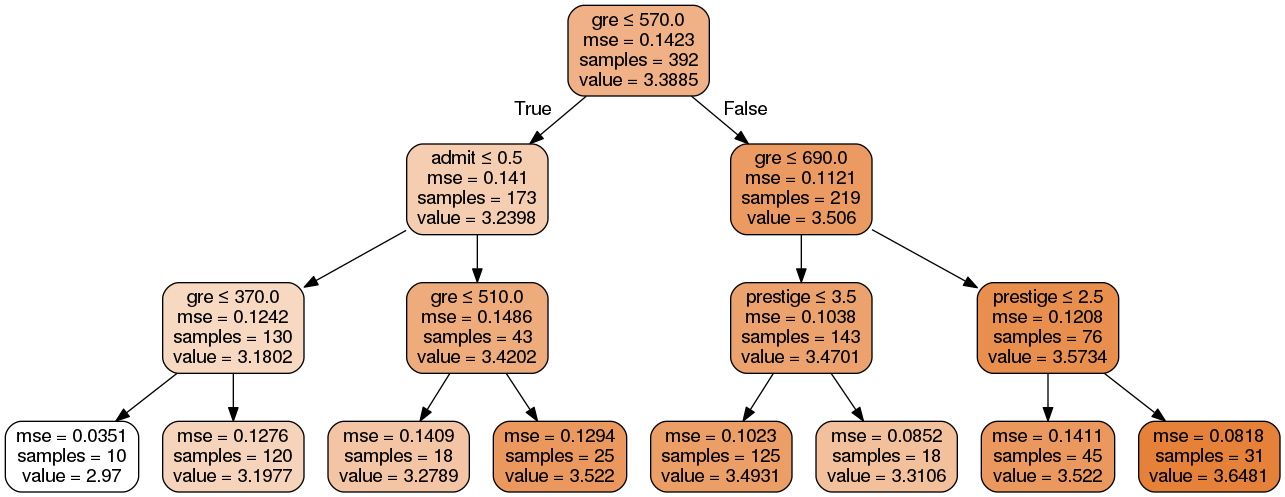

In [37]:
reg = DecisionTreeRegressor(max_depth=3, random_state=2)
reg.fit(Xr,yr)
viz_tree(reg)

---

### Building classification trees

With `DecisionTreeClassifier`:

1. Again build 4 models with different parameters for `max_depth`: `max_depth=1`, `max_depth=2`, `max_depth=3`, and `max_depth=None`
2. Cross-validate the accuracy scores of each of the models and compare to the logistic regression earlier.

Note that now you'll be using the classification task where we are predicting `admit`.

In [38]:
trees = []
for i in [1,2,3,None]:
    classifier = DecisionTreeClassifier(max_depth=i, random_state=0)
    classifier.fit(Xc,yc)
  
    trees.append(classifier)
    print("max_depth: " + str(i))
    print("score: " + str(np.mean(cross_val_score(classifier, Xc,yc, cv=4))))

max_depth: 1
score: 0.686234318782
max_depth: 2
score: 0.683526034594
max_depth: 3
score: 0.724320312317
max_depth: None
score: 0.625006641207


The scores appear to be much better!

---

### Visualize the classification trees

The plotting code will be the same as for regression, you just need to change the model you're using for each plot and the feature names.

The output changes somewhat from the regression tree chart. Earlier it would give the MSE of that node, but now there is a line called `value` that tells you the count of each class at that node.

<bound method DecisionTreeClassifier.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')>


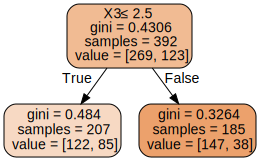

---------------------------------------------
<bound method DecisionTreeClassifier.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')>


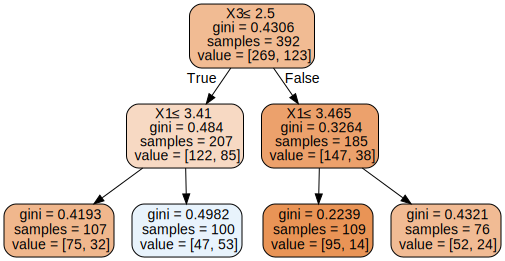

---------------------------------------------
<bound method DecisionTreeClassifier.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')>


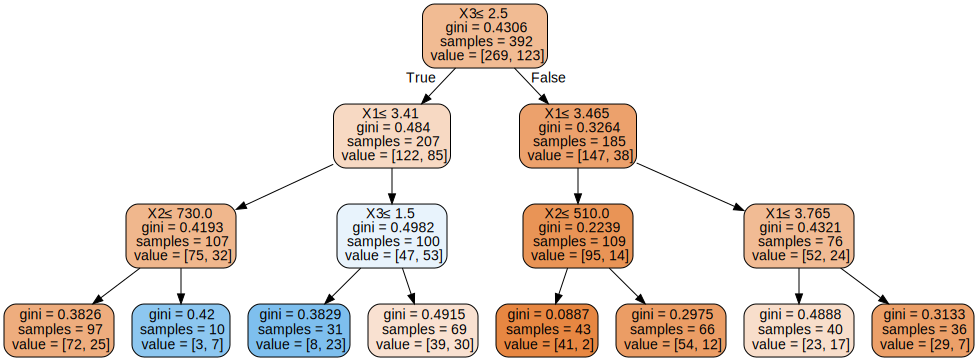

---------------------------------------------
<bound method DecisionTreeClassifier.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')>


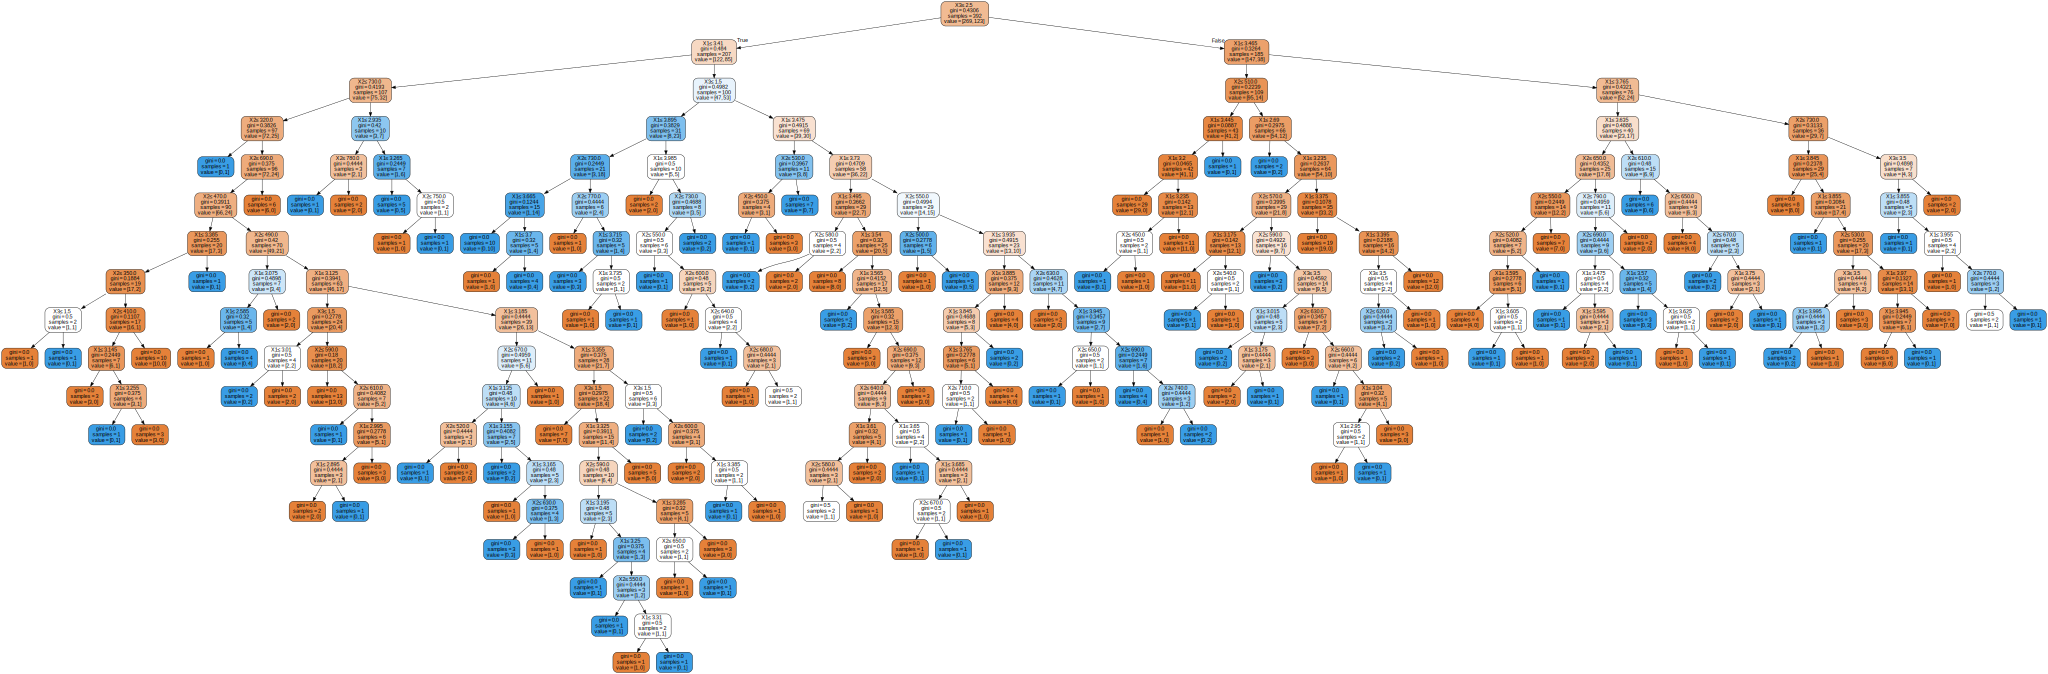

---------------------------------------------


In [39]:
import graphviz

for (i,tree) in enumerate(trees):
    print(tree.get_params)
    export_graphviz(tree, out_file="mytree" + str(i) + ".dot", 
                        filled=True, rounded=True,
                        special_characters=True)
    with open("mytree" + str(i) + ".dot") as f:
            dot_graph = f.read()
            display(graphviz.Source(dot_graph))
    print("---------------------------------------------")


---

### Using GridSearchCV to find the best decision tree classifier

Decision tree regression and classification models in sklearn offer a variety of ways to "pre-prune" (by restricting the how many times the tree can branch and what it can use).

Measure           | What it does
------------------|-------------
max_depth         | How many nodes deep can the decision tree go?
max_features      | Is there a cut off to the number of features to use?
max_leaf_nodes    | How many leaves can be generated per node?
min_samples_leaf  | How many samples need to be included at a leaf, at a minimum?  
min_samples_split | How many samples need to be included at a node, at a minimum?

It is not always best to search over _all_ of these in a grid search, unless you have a small dataset. Many of them while not redundant are going to have very similar effects on your model's fit.

Check out the documentation here:

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

---

## Switch over to the college stats dataset for the rest of the lab.

We are going to be predicting whether or not a college is public or private. Set up your `X`, `y` variables accordingly.

In [40]:
import pandas as pd
col = pd.read_csv('assets/college.csv')

---

### Set up and run the GridSearch on the college data, building the best decision tree classifier.

In [41]:
from sklearn.model_selection import GridSearchCV
y = col.Private == 'Yes'
X = col.iloc[:, 2:]

dtc_params = {
    'max_depth':[None,1,2,3],
    'max_features':[None,'log2','sqrt',2,3,5],
    'min_samples_split':[2,5,10,30,50]
}


dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)

In [42]:
dtc_gs.fit(X, y)
dtc_best = dtc_gs.best_estimator_
print(dtc_gs.best_params_)
print(dtc_gs.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'max_features': 'sqrt', 'min_samples_split': 10, 'max_depth': 3}
0.911196911197


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.1s finished


### Build a bagging classifier using GridSearchCV.

In [43]:
from sklearn.ensemble import BaggingClassifier

dtc_params = {
    'max_features': [0.5, 0.7, 1.0],
    'max_samples': [0.5, 0.7, 1.0],
    'n_estimators': [2, 5, 10, 20],
}

dtc_gs = GridSearchCV(BaggingClassifier(), dtc_params, cv=5, verbose=1)
dtc_gs.fit(X, y)
dtc_best = dtc_gs.best_estimator_
print(dtc_gs.best_params_)
print(dtc_gs.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 20}
0.947232947233


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    5.7s finished


### Build a Random Forest classifier using GridSearchCV.

In [54]:
from sklearn.ensemble import RandomForestClassifier

dtc_params = {
    'max_features': [0.5, 0.7, 1.0],
    'n_estimators': [2, 5, 10, 20,35,40,100],
    'max_depth': [2, 5, 10, 20],
}

dtc_gs = GridSearchCV(RandomForestClassifier(), dtc_params, cv=5, verbose=1)
dtc_gs.fit(X, y)
dtc_best = dtc_gs.best_estimator_
print(dtc_gs.best_params_)
print(dtc_gs.best_score_)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:   54.4s finished


{'max_features': 0.7, 'n_estimators': 100, 'max_depth': 10}
0.940797940798


### Build an ExtraTrees classifier using GridSearchCV.

In [49]:
from sklearn.ensemble import ExtraTreesClassifier

dtc_params = {
    'max_features': [0.5, 0.7, 1.0],
    'n_estimators': [2, 5, 10, 20,35,40,100],
    'max_depth': [2, 5, 10, 100],
}

dtc_gs = GridSearchCV(RandomForestClassifier(), dtc_params, cv=5, verbose=1)
dtc_gs.fit(X, y)
dtc_best = dtc_gs.best_estimator_
print(dtc_gs.best_params_)
print(dtc_gs.best_score_)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:   53.6s finished


{'max_features': 0.5, 'n_estimators': 100, 'max_depth': 100}
0.943371943372


### Compare the best models. Based on GridSearchCV, which is the best model to build? Build it.

The bagged decision tree had the highest score.

In [50]:
from sklearn.ensemble import BaggingClassifier

dtc_params = {
    'max_features': [0.5, 0.7, 1.0],
    'max_samples': [0.5, 0.7, 1.0],
    'n_estimators': [2, 20,50,100],
}

dtc_gs = GridSearchCV(BaggingClassifier(), dtc_params, cv=5, verbose=1)
dtc_gs.fit(X, y)
dtc_best = dtc_gs.best_estimator_


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   21.3s finished


In [51]:
print(dtc_gs.best_params_)
print(dtc_gs.best_score_)

{'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 50}
0.947232947233


In [47]:
# Got this code from stack overflow. It is what Randomforrest does OOB. Averages the importances from each of
# the ensemble trees.
feature_importances = np.mean([
    tree.feature_importances_ for tree in dtc_best.estimators_
], axis=0)

---

### Print out the "feature importances" of this best model.

The model has an attribute called `.feature_importances_` which can tell us which features were most important vs. others. It ranges from 0 to 1, with 1 being the most important.

An easy way to think about the feature importance is how much that particular variable was used to make decisions. Really though, it also takes into account how much that feature contributed to splitting up the class or reducing the variance.

A feature with higher feature importance reduced the criterion (impurity) more than the other features.

Below, show the feature importances for each variable predicting private vs. not, sorted by most important feature to least.

In [48]:
# I am printing my feature importances here... I have sorted them if that is what you are asking for
sorted(zip(X.columns, feature_importances),key=lambda a : a[1])

[('P.Undergrad', 0.10572039845884601),
 ('Top10perc', 0.10721892967068068),
 ('F.Undergrad', 0.10824780720732244),
 ('Outstate', 0.12035410144019379),
 ('Apps', 0.12770166371441671),
 ('Top25perc', 0.13130889758887265),
 ('Accept', 0.14282493186874434),
 ('Enroll', 0.15662327005092339)]